In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import sys
import os
project_path = os.path.expanduser('~/repos/laplace_operator_metric_graph/')
sys.path.append(project_path)
import construct_graph
import solve_laplace_operator
from helper_functions import style_plot, sequential_Newton

%load_ext autoreload
%autoreload 2

#### Load eigenvalues

In [2]:
with open("../data/rgg_eigenvalues.pkl", "rb") as file:
    torus_eigenvalues = pickle.load(file) # torus_eigenvalues[num_Vs][seed] gives the first 4 non-trivial eigenvalues)

#### Verify that calculated eigenvalues match loaded values

In [4]:
num_Vs = 1000
seed = 0

np.random.seed(seed)

g = construct_graph.patch_graph.RGG(num_Vs)
g = construct_graph.patch_graph.Patch(g)

eigs = solve_laplace_operator.solve_laplace_operator.Eigenvalue_Calculator(g)
guesses = np.linspace(2.7, 3.9, 30)
full_solutions = sequential_Newton(guesses, eigs, min_eigenvalue=0, max_eigenvalue=10)
eigenvalue_data = full_solutions.copy()

print()
print(f"calculated eigenvalues \t\t = {eigenvalue_data}")
print(f"eigenvalues from loaded data \t = {torus_eigenvalues[num_Vs][seed]}")


Calculating eig number 0

----------------------
Converged at step 1:

k = 3.259418374147442
----------------------

Calculating eig number 1

----------------------
Converged at step 1:

k = 3.3611405755832213
----------------------

Calculating eig number 2

----------------------
Converged at step 1:

k = 3.736170361990319
----------------------

Calculating eig number 3

----------------------
Converged at step 1:

k = 3.8580457238171246
----------------------

calculated eigenvalues 		 = [3.25941837 3.36114058 3.73617036 3.85804572]
eigenvalues from loaded data 	 = [3.25941837 3.36114058 3.73617036 3.85804572]


#### Load relative errors for eigenvalues/functions 

In [10]:
with open("../data/rgg_eigenmode_rel_errs.pkl", "rb") as file:
    rel_errs = pickle.load(file)

#### Verify that relative errors calculated from scratch match with loaded values

In [6]:
m, n = 0, 1
problem = "square_flat_torus"
graph_type = "rgg"

graph_ks = eigenvalue_data.copy()
p = solve_laplace_operator.solve_laplace_operator_update.Projector(g, m, n, torus_eigenvalues[num_Vs][seed], problem, graph_type)

print(f"Eigenvalue relative errors \t\t = {p.data[0]}")
print(f"Eigenvalue relative errors loaded \t = {rel_errs['square_flat_torus'][num_Vs]['eigenvalues'][seed]}")
print(f"Eigenfunction relative errors \t\t = {p.data[1]}")
print(f"Eigenfunction relative errors loaded \t = {rel_errs['square_flat_torus'][num_Vs]['eigenfunctions'][seed]}")

Eigenvalue relative errors 		 = [0.20630774 0.15599449 0.04285822 0.11200482]
Eigenvalue relative errors loaded 	 = [0.20630774 0.15599449 0.04285822 0.11200482]
Eigenfunction relative errors 		 = [0.30682767 0.33294952 0.2928011  0.29771278]
Eigenfunction relative errors loaded 	 = [0.30682767 0.33294952 0.2928011  0.29771278]


#### Plot modes

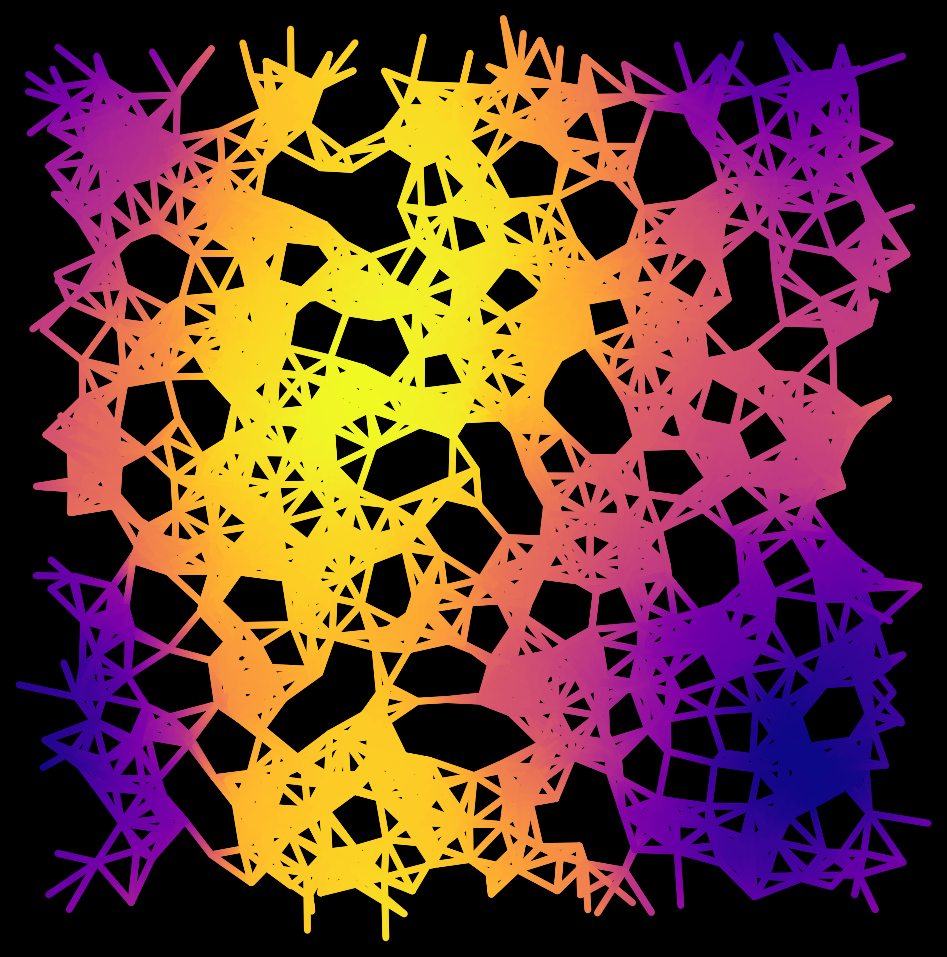

In [7]:
mode_number = 0
g.plot_graph(eigenmode=p.graph_eigenfunctions[mode_number].data, background_color="black", figsize=10)

#### Set up data for plotting

In [8]:
torus_nums_Vs = np.array(list(rel_errs["square_flat_torus"].keys()))
all_nums_Vs = [torus_nums_Vs]

rel_errs_plot_data = {"eigenvalues": {}, "eigenfunctions": {}}
for graph in rel_errs:
    rel_errs_plot_data["eigenvalues"][graph] = {"mean": [], "error_upper": [], "error_lower": []}
    rel_errs_plot_data["eigenfunctions"][graph] = {"mean": [], "error_upper": [], "error_lower": []}

    for data_type in ["eigenvalues", "eigenfunctions"]:

        for data in rel_errs[graph].values():

            data_type_data = np.array(data[data_type])

            means = np.mean(data_type_data)
            stds = np.std(data_type_data)
            y_ratio_upper = means * (1 + stds / means)  
            y_ratio_lower = means / (1 + stds / means)
            error_upper = y_ratio_upper - means
            error_lower = means - y_ratio_lower

            rel_errs_plot_data[data_type][graph]["mean"].append(means)
            rel_errs_plot_data[data_type][graph]["error_upper"].append(error_upper)
            rel_errs_plot_data[data_type][graph]["error_lower"].append(error_lower)

        rel_errs_plot_data[data_type][graph]["mean"] = np.array(rel_errs_plot_data[data_type][graph]["mean"])
        rel_errs_plot_data[data_type][graph]["error_upper"] = np.array(rel_errs_plot_data[data_type][graph]["error_upper"])
        rel_errs_plot_data[data_type][graph]["error_lower"] = np.array(rel_errs_plot_data[data_type][graph]["error_lower"])

#### Plot

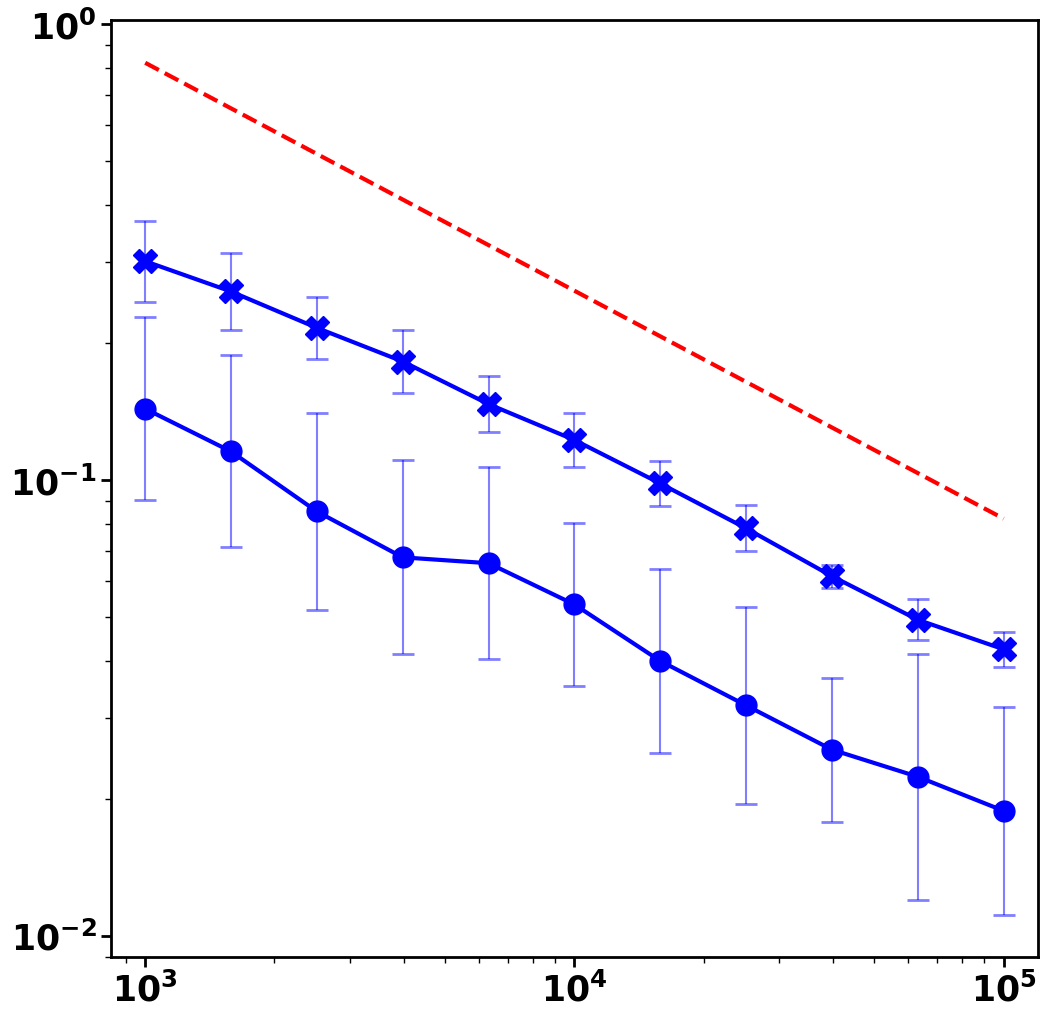

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

colors = ["b"]
eigenvalue_linewidth = 3
eigenvalue_markersize = 15
markers = ["o", "X"]
ms = [eigenvalue_markersize, eigenvalue_markersize*1.15]

for data_en, data_type in enumerate(rel_errs_plot_data):

    for en, problem in enumerate(rel_errs_plot_data[data_type]):

        ax.loglog(all_nums_Vs[en], rel_errs_plot_data[data_type][problem]["mean"], 
                  f'{markers[data_en]}-', c=colors[en], linewidth=eigenvalue_linewidth, markersize=ms[data_en])

        ax.errorbar(all_nums_Vs[en], rel_errs_plot_data[data_type][problem]["mean"], 
                    yerr=[rel_errs_plot_data[data_type][problem]["error_lower"], 
                          rel_errs_plot_data[data_type][problem]["error_upper"]], 
                    capsize=8, capthick=2, c=colors[en], alpha=0.5, zorder=0)

ax.loglog(np.linspace(1000, 100000, 2), np.linspace(1000, 100000, 2)**(-0.5) * 26, 
        '--', c="r", linewidth=eigenvalue_linewidth, markersize=eigenvalue_markersize)

x_min, x_max = all_nums_Vs[en].min(), all_nums_Vs[en].max()
ax.set_xlim(10**(np.log10(x_min) - 0.08), 10**(np.log10(x_max) + 0.08))

style_plot(fig, ax, aspect=None)